### Model training updates

update 1 - retraining the model with the clean esec data (non flows, non rockfalls, non earthquakes). 

update 2 - June 20, 2025 - retraining the model with 2502 near field  (0-50 km) explosions waveforms that were classified as surface events and earthquakes. 

In [58]:
%load_ext autoreload
%autoreload 2

# === Standard Libraries ===
import os
import sys
import random
import json
from typing import Any

# === Scientific Libraries ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob

# === Signal Processing ===
import scipy
from scipy import signal
from scipy.signal import butter, filtfilt, correlate

# === Seismology Libraries ===
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

# === Machine Learning Libraries ===
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

# === PyTorch ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# === File Handling ===
import h5py

# === Custom Modules ===
module_path = os.path.abspath(os.path.join('../scripts'))
if module_path not in sys.path:
    sys.path.append(module_path)

from sklearn.model_selection import train_test_split
from neural_network_architectures import (
     QuakeXNet_1d, QuakeXNet_2d, SeismicCNN_1d, SeismicCNN_2d )


# === Seismology Client ===
client = Client('IRIS')

from utils import extract_waveforms
from utils import compute_spectrogram
from utils import normalize_spectrogram_minmax
from utils import return_train_val_loaders
from utils import plot_confusion_matrix_and_cr
from utils import train_model
from utils import WaveformPreprocessor


import json

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Additional surface event data per station

###  I downloaded additional surface event data by downloading from more stations from event to supplement existing data.  the step below is just processing those additionally downloaded waveforms and these will be added later to the the total dataset. 

In [59]:
nos = 2000

# if we are taking all data or not. 
all_data = False

# the start point will be selected randomly from (start, -4)
start = - 40
shifting = True

# training parameters
train_split = 70                                      
val_split=20
test_split = 10
learning_rate=0.001
batch_size=128
n_epochs=60
dropout=0.4
criterion=nn.CrossEntropyLoss()


num_channels = 3
# new sampling rate
fs = 50

## filtering parameters
highcut = 20
lowcut = 1
input_window_length = 100

# randomly starting between -40 to -5s
start = -40

In [60]:
def process_surface_events(data_path, ids_path, fs=50, original_fs = 100, lowcut=1, highcut=20, window_length=100, taper_alpha=0.1, random_offset=(-40, 40)):
    """
    Processes surface event data by applying tapering, bandpass filtering, resampling, and normalization.
    
    Args:
        data_path (str): Path to the surface event data (.npy file).
        ids_path (str): Path to the surface event IDs (JSON file).
        fs (int): Sampling rate for resampling.
        lowcut (float): Low cutoff frequency for bandpass filter.
        highcut (float): High cutoff frequency for bandpass filter.
        window_length (int): Length of the waveform window (in seconds).
        taper_alpha (float): Alpha value for the Tukey window.
        random_offset (tuple): Range of random offsets for slicing data.
        
    Returns:
        list: Processed waveform data.
        list: Corresponding event IDs.
    """
    # Load data and IDs
    surface_data = np.load(data_path, allow_pickle=True)
    with open(ids_path, "r") as file:
        surface_ids = json.load(file)


    processed_data = []
    processed_ids = []

    # Process each event
    for i in tqdm(range(len(surface_data)), desc="Processing events"):
        try:
            event_data = surface_data[i]
            
            orig_fs = 100
            
            # Randomly select a window of the specified length
            random_shift = np.random.randint(random_offset[0], random_offset[1]) * orig_fs
            
            # assuming the onset at 90s
            start_idx = int(90 * orig_fs) + random_shift
            end_idx = start_idx + int(window_length * orig_fs)
            
    
            # Handle boundary conditions
            max_idx = event_data.shape[-1]
            if end_idx > max_idx:
                end_idx = max_idx
                start_idx = end_idx - int(window_length * orig_fs)
            if start_idx < 0:
                start_idx = 0
                end_idx = int(window_length * orig_fs)
                
                
            sliced = event_data[:, start_idx:end_idx]
            

            
            sliced_tensor = torch.tensor(sliced, dtype=torch.float32)

            
            processor = WaveformPreprocessor(
            input_fs=original_fs,
            target_fs=fs,
            lowcut=lowcut,
            highcut=highcut)
            
            processed = processor(sliced_tensor)  # (C, T)
            
   

            if processed.shape[-1] != int(window_length*fs):
                print('error')
                continue

            x = processed.numpy()
            
            if len(x) == 3:  # Ensure the event has three components
                processed_data.append(x)
                processed_ids.append(surface_ids[i])

        except Exception as e:
            # Log or print the exception if needed
            print(f"Error processing event {i}: {e}")
            continue

    return processed_data, processed_ids


# Example usage
data_path = '../../data/new_curated_surface_event_data.npy'
ids_path = '../../data/new_curated_surface_event_ids.json'

processed_additional_su, processed_additional_su_id = process_surface_events(data_path, ids_path)

print(f'Length of additional surface event waveforms {len(processed_additional_su)}')

Processing events: 100%|██████████| 6495/6495 [00:12<00:00, 529.41it/s]


Length of additional surface event waveforms 6487


## 2. Original PNW data

In [61]:
#data files
file_noise="/data/whd01/yiyu_data/PNWML/noise_waveforms.hdf5";
file_comcat=  "/data/whd01/yiyu_data/PNWML/comcat_waveforms.hdf5";
file_exotic="/data/whd01/yiyu_data/PNWML/exotic_waveforms.hdf5";

# metadata
# accessing the comcat metadata
comcat_metadata = pd.read_csv("/data/whd01/yiyu_data/PNWML/comcat_metadata.csv")
# comcat_metadata = pd.read_csv("/data/whd01/yiyu_data/PNWML/comcat_metadata.csv")

# accessing the exotic metadata
exotic_metadata = pd.read_csv("/data/whd01/yiyu_data/PNWML/exotic_metadata.csv")
# exotic_metadata = pd.read_csv("/data/whd01/yiyu_data/PNWML/exotic_metadata.csv")

# accessing the data files
metadata_noise = pd.read_csv("/data/whd01/yiyu_data/PNWML/noise_metadata.csv")
# metadata_noise = pd.read_csv("/data/whd01/yiyu_data/PNWML/noise_metadata.csv")

# creating individual data frames for each class
cat_exp = comcat_metadata[comcat_metadata['source_type'] == 'explosion']
cat_eq = comcat_metadata[comcat_metadata['source_type'] == 'earthquake']
cat_su = exotic_metadata[exotic_metadata['source_type'] == 'surface event']
cat_noise = metadata_noise
cat_noise['event_id'] = [cat_noise['trace_start_time'][i]+'_noise' for i in range(len(cat_noise))]

In [62]:
## defining the threshold
SNR_THR = 1

# explosions
trace_snr_db_values = np.array([float(cat_exp.loc[idx, 'trace_snr_db'].split("|")[-1]) for idx in cat_exp.index.values.tolist()])
ii2= np.where(trace_snr_db_values>SNR_THR)[0].astype(int) 
df_exp = cat_exp.iloc[ii2]

# earthquake
trace_snr_db_values = np.array([float(cat_eq.loc[idx, 'trace_snr_db'].split("|")[-1]) for idx in cat_eq.index.values.tolist()])
ii2= np.where(trace_snr_db_values>SNR_THR)[0].astype(int) 
df_eq = cat_eq.iloc[ii2]

# surface events
trace_snr_db_values = np.array([float(cat_su.loc[idx, 'trace_snr_db'].split("|")[-1]) for idx in cat_su.index.values.tolist()])
ii2= np.where(trace_snr_db_values>SNR_THR-2)[0].astype(int) 
df_su = cat_su.iloc[ii2]

# noise
# does not change
df_noise = cat_noise

## note that we are only selecting three component events from dataset 

In [63]:
number_data_per_class = len(df_su)
# surface events
d_su, id_su = extract_waveforms(df_su, file_exotic, input_window_length = input_window_length, fs=fs,
                                start =start, number_data = number_data_per_class, num_channels = num_channels,
                                shifting = shifting, all_data = all_data, lowcut = lowcut , highcut =highcut)
print(d_su.shape)



number_data_per_class = 15000
# noise
d_noise, id_noise = extract_waveforms(df_noise, file_noise, input_window_length = input_window_length, fs=fs,
                                      start = start, number_data = number_data_per_class,
                                      num_channels = num_channels, shifting = shifting, all_data = all_data, lowcut = lowcut , highcut =highcut)
print(d_noise.shape)



number_data_per_class = len(df_exp)
# explosions
d_exp, id_exp = extract_waveforms(df_exp, file_comcat, input_window_length = input_window_length, fs=fs,
                                  start = start,  number_data = number_data_per_class, num_channels = num_channels,
                                  shifting = shifting, all_data = all_data, lowcut = lowcut , highcut =highcut)

print(d_exp.shape)


number_data_per_class = 17000
# earthquakes
d_eq, id_eq = extract_waveforms(df_eq, file_comcat, input_window_length = input_window_length,  fs=fs,
                                start =start,  number_data = number_data_per_class, num_channels = num_channels,
                                shifting = shifting, all_data = all_data, lowcut = lowcut , highcut =highcut)
print(d_eq.shape)

  0%|          | 0/15000 [00:00<?, ?it/s]

(3778, 3, 5000)


  0%|          | 48/13638 [00:00<00:28, 469.88it/s]

(10517, 3, 5000)


  0%|          | 0/17000 [00:00<?, ?it/s]

(8793, 3, 5000)


100%|██████████| 17000/17000 [03:07<00:00, 90.89it/s] 


(10487, 3, 5000)


In [65]:
np.save("d_eq.npy", d_eq)
np.save("d_exp.npy", d_exp)
np.save("d_su.npy", d_su)
np.save("d_noise.npy", d_noise)

np.save("id_eq.npy", id_eq)
np.save("id_exp.npy", id_exp)
np.save("id_su.npy", id_su)
np.save("id_noise.npy", id_noise)


In [67]:
d_eq = np.load("d_eq.npy")
d_exp = np.load("d_exp.npy")
d_su = np.load("d_su.npy")
d_noise = np.load("d_noise.npy")

id_eq = np.load("id_eq.npy", allow_pickle = True)
id_exp = np.load("id_exp.npy", allow_pickle = True)
id_su = np.load("id_su.npy", allow_pickle = True)
id_noise = np.load("id_noise.npy", allow_pickle = True)


## 3. ESEC waveforms (1866 waveforms)

In [68]:
df = pd.read_csv('../../data/curated_esec_catalog_for_retraining.csv',index_col = 0)

In [69]:
df

,event_id,station,prob_eq,prob_px,prob_noise,prob_surface,max_prob,assigned_label,snr_n,event_label_x,event_label_y,type
0,74,SLD,0.009431,0.606736,0.999952,0.979550,0.979550,surface,10.354430,surface,surface,rock avalanche
1,130,PLBC,0.002547,0.965852,0.999910,0.022586,0.965852,px,12.442687,px,px,rock avalanche
2,160,N19K,0.077101,0.220457,0.999976,0.766895,0.766895,surface,12.884728,surface,surface,ice avalanche
3,160,O18K,0.241163,0.072579,0.998638,0.925733,0.925733,surface,13.624922,surface,surface,ice avalanche
4,160,O19K,0.036180,0.535932,0.995490,0.585888,0.585888,surface,7.214448,surface,surface,ice avalanche
...,...,...,...,...,...,...,...,...,...,...,...,...
2251,227,D156,0.565975,0.729836,0.999775,0.040341,0.729836,px,8.105497,surface,surface,rock fall
2252,227,D160,0.705087,0.286322,0.999996,0.959258,0.959258,surface,9.703775,surface,surface,rock fall
2254,227,D163,0.000114,0.028818,0.999224,0.980757,0.980757,surface,22.175401,surface,surface,rock fall
2255,227,KBA,0.015515,0.234649,0.999980,0.906808,0.906808,surface,74.285297,surface,surface,rock fall


In [70]:
esec_data = []
esec_ids = []

for i in tqdm(range(len(df))):
    try:
        event_id = df['event_id'].iloc[i]
        station = df['station'].iloc[i]

        # Find all vertical component files for the event and station
        files = glob(f"../../data/iris_esec_waveforms/waveforms/{event_id}/*{station}*")

        if len(files) == 3:
            st = obspy.Stream()
            for file in files:
                st += obspy.read(file)
            
            
            st.resample(100)

            # Convert to NumPy array and clip length to 27000 samples (if possible)
            arr = np.stack([tr.data[:27000] for tr in st])
            esec_data.append(arr)
            esec_ids.append(event_id)

    except Exception as e:
        print(f"Error on index {i}, event {df['event_id'].iloc[i]}: {e}")
        continue


100%|██████████| 1866/1866 [00:26<00:00, 70.22it/s]


In [71]:
esec_data = np.array(esec_data)
esec_ids = np.array(esec_ids)

In [72]:
processed_data = []
processed_ids = []
random_offset=(-40, 40)
fs=50 
original_fs = 100
lowcut=1
highcut=20
window_length=100
taper_alpha=0.1
orig_fs = 100

processed_esec_data = []
processed_esec_ids = []

for i in tqdm(range(len(esec_data))):
    event_data = esec_data[i]
    random_shift = np.random.randint(random_offset[0], random_offset[1]) * orig_fs


    # assuming the onset at 90s
    start_idx = int(105 * orig_fs) + random_shift
    end_idx = start_idx + int(window_length * orig_fs)

    # Handle boundary conditions
    max_idx = event_data.shape[-1]
    if end_idx > max_idx:
        end_idx = max_idx
        start_idx = end_idx - int(window_length * orig_fs)
    if start_idx < 0:
        start_idx = 0
        end_idx = int(window_length * orig_fs)



    sliced = event_data[:, start_idx:end_idx]
    sliced_tensor = torch.tensor(sliced, dtype=torch.float32)


    processor = WaveformPreprocessor(
    input_fs=original_fs,
    target_fs=fs,
    lowcut=lowcut,
    highcut=highcut)

    processed = processor(sliced_tensor)  # (C, T)


    if processed.shape[-1] != int(window_length*fs):
        print('error')
        continue

    x = processed.numpy()
    
    if len(x) == 3:  # Ensure the event has three components
        processed_esec_data.append(x)
        processed_esec_ids.append(esec_ids[i])
        
    

100%|██████████| 1866/1866 [00:03<00:00, 545.42it/s]


## 4. New near field explosions data

In [73]:
new_exp_df = pd.read_csv('../../data/curated_new_explosions_data_for_retraining.csv',index_col = 0)

In [74]:
print(len(new_exp_df))

2502


In [75]:
new_exp_data = []
new_exp_ids = []

for i in tqdm(range(len(new_exp_df))):
    try:
        event_id = new_exp_df['event_id'].iloc[i]
        station = new_exp_df['station'].iloc[i]

        # Find all vertical component files for the event and station
        files = glob(f"../../data/pnw_new_explosion_2023_2025/waveforms/{event_id}/*{station}*")

        if len(files) == 3:
            st = obspy.Stream()
            for file in files:
                st += obspy.read(file)
            
            
            st.resample(100)

            # Convert to NumPy array and clip length to 27000 samples (if possible)
            arr = np.stack([tr.data[:27000] for tr in st])
            new_exp_data.append(arr)
            new_exp_ids.append(event_id)

    except Exception as e:
        print(f"Error on index {i}, event {new_exp_df['event_id'].iloc[i]}: {e}")
        continue


100%|██████████| 2502/2502 [00:23<00:00, 106.76it/s]


In [76]:
new_exp_data = np.array(new_exp_data)
new_exp_ids = np.array(new_exp_ids)

In [77]:
processed_data = []
processed_ids = []
random_offset=(-40, 40)
fs=50 
original_fs = 100
lowcut=1
highcut=20
window_length=100
taper_alpha=0.1
orig_fs = 100

processed_new_exp_data = []
processed_new_exp_ids = []

for i in tqdm(range(len(new_exp_data))):
    event_data = new_exp_data[i]
    random_shift = np.random.randint(random_offset[0], random_offset[1]) * orig_fs


    # assuming the onset at 90s
    start_idx = int(70 * orig_fs) + random_shift
    end_idx = start_idx + int(window_length * orig_fs)

    # Handle boundary conditions
    max_idx = event_data.shape[-1]
    if end_idx > max_idx:
        end_idx = max_idx
        start_idx = end_idx - int(window_length * orig_fs)
    if start_idx < 0:
        start_idx = 0
        end_idx = int(window_length * orig_fs)



    sliced = event_data[:, start_idx:end_idx]
    sliced_tensor = torch.tensor(sliced, dtype=torch.float32)


    processor = WaveformPreprocessor(
    input_fs=original_fs,
    target_fs=fs,
    lowcut=lowcut,
    highcut=highcut)

    processed = processor(sliced_tensor)  # (C, T)


    if processed.shape[-1] != int(window_length*fs):
        print('error')
        continue

    x = processed.numpy()
    
    if len(x) == 3:  # Ensure the event has three components
        processed_new_exp_data.append(x)
        processed_new_exp_ids.append(new_exp_ids[i])
        
    

100%|██████████| 2502/2502 [00:04<00:00, 540.75it/s]


## Preparing training and testing data

## We are keeping it such that the original testing data remains unaffected. And all the new and additional esec and explosion events will be added to the training dataset. 

In [78]:
def prepare_data(d_eq, d_exp, d_noise, d_su, processed = processed_additional_su, processed_ids = processed_additional_su_id, num_samples=10000):
    """
    Prepares and concatenates seismic data for training and testing.
    
    Args:
        d_eq, d_exp, d_noise, d_su (array): Arrays of waveform data for different classes.
        processed (array): Processed surface waveforms.
        processed_ids (array): Corresponding IDs for processed surface waveforms.
        num_samples (int): Number of samples to extract per class.

    Returns:
        tuple: Combined waveforms (new_X_1d), event IDs (new_X), and labels (new_y).
    """
    # Extract the required number of samples per class
    new_d_eq = d_eq[:num_samples]
    new_d_exp = d_exp[:num_samples]
    new_d_no = d_noise[:num_samples]
    new_d_su = np.concatenate([d_su, np.array(processed)])[:num_samples]

    # Extract corresponding event IDs
    new_id_eq = id_eq[:num_samples]
    new_id_exp = id_exp[:num_samples]
    new_id_no = id_noise[:num_samples]
    new_id_su = np.concatenate([id_su, np.array(processed_ids)])[:num_samples]

    # Combine data into single arrays
    new_X_1d = np.vstack([new_d_eq, new_d_exp, new_d_no, new_d_su])  # Waveforms
    new_X = np.hstack([new_id_eq, new_id_exp, new_id_no, new_id_su])  # Event IDs
    new_y = (
        [0] * len(new_d_eq) + 
        [1] * len(new_d_exp) + 
        [2] * len(new_d_no) + 
        [3] * len(new_d_su)
    )  # Labels
    
    return new_X_1d, new_X, new_y

def split_and_save_data(new_X, new_X_1d, new_y, test_size=0.2, random_state=42, save_path="../../data"):
    """
    Splits data into training and testing, and saves the results to disk.
    
    Args:
        new_X (array): Event IDs.
        new_X_1d (array): Waveform data.
        new_y (list): Labels for the event IDs.
        test_size (float): Proportion of test data.
        random_state (int): Random state for reproducibility.
        save_path (str): Directory to save the test data IDs.
    """
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        new_X, new_y, test_size=test_size, random_state=random_state, stratify=new_y
    )
    
    # Create a mapping of event IDs to indices
    event_id_to_index = {event_id: idx for idx, event_id in enumerate(new_X)}
    
    # Retrieve indices for test and train data
    test_indices = [event_id_to_index[event_id] for event_id in X_test]
    train_indices = [event_id_to_index[event_id] for event_id in X_train]
    
    # Extract waveforms for train and test sets
    test_waveforms = new_X_1d[test_indices]
    train_waveforms = new_X_1d[train_indices]
    
    # Save test data IDs for future use
    np.save(f"{save_path}/common_test_data_id.npy", X_test)
    np.save(f"{save_path}/common_test_data_for_deep_learning.npy", test_waveforms)
    np.save(f"{save_path}/common_test_data_labels_for_deep_learning.npy", y_test)
    
    print("Shape of test_waveforms:", test_waveforms.shape)
    print("Shape of train_waveforms:", train_waveforms.shape)

    return train_waveforms, test_waveforms, y_train, y_test


# Example usage:
new_X_1d, new_X, new_y = prepare_data(d_eq, d_exp, d_noise, d_su, processed_additional_su, processed_additional_su_id, num_samples=10000)
train_waveforms, test_waveforms, y_train, y_test = split_and_save_data(new_X, new_X_1d, new_y)

Shape of test_waveforms: (7759, 3, 5000)
Shape of train_waveforms: (31034, 3, 5000)


## Data Augmentation Strategy

**Adding esec data to training dataset** - So we will first add the esec surface event waveforms to surface events.

**Adding new explosion data** - we will add the new explosion waveforms to explosions and 

**Balancing of the class** - Then we will augment each class so that each class have equal number of waveforms. 

In [79]:
def augment_with_noise_numpy(data, noise_pool, scale = 0.5, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    indices = np.random.randint(0, len(noise_pool), size=len(data))
    noise_samples = noise_pool[indices]
    
    return data + scale * noise_samples




y_train = np.array(y_train)
X_train = train_waveforms
d_eq_train  = X_train[y_train == 0]
d_exp_train = X_train[y_train == 1]
d_noise_train = X_train[y_train == 2]
d_su_train = X_train[y_train == 3]



# augmented waveforms
aug_eq  = augment_with_noise_numpy(d_eq_train, d_noise_train)
aug_exp = augment_with_noise_numpy(d_exp_train, d_noise_train)
aug_su  = augment_with_noise_numpy(d_su_train,  d_noise_train)
aug_no  = augment_with_noise_numpy(d_noise_train,  d_noise_train)


# adding the esec data to surface events
d_su_train = np.concatenate([d_su_train, np.array(processed_esec_data)], axis = 0)

# adding the near field explosion data to explosions
d_exp_train = np.concatenate([d_exp_train, np.array(processed_new_exp_data)], axis = 0)

In [80]:
print(f'No. of eqs in training: {len(d_eq_train)}')
print(f'No. of pxs in training: {len(d_exp_train)}')
print(f'No. of surface events in training: {len(d_su_train)}')
print(f'No. of noise in training: {len(d_noise_train)}')


No. of eqs in training: 8000
No. of pxs in training: 9536
No. of surface events in training: 9866
No. of noise in training: 8000


## ok so now we have to select just enough number of waveforms from augmented dataset so that all of the classes have equal number of events. The augmented set contains 8000 waveforms per class

In [81]:
#ensuring the class balance. 
aug_eq = aug_eq
aug_no = aug_no
aug_exp = aug_exp[:16000 - len(d_exp_train)]
aug_su = aug_su[:16000 - len(d_su_train)]

X_train_aug = np.concatenate([d_eq_train, d_exp_train, d_su_train, d_noise_train,
                         aug_eq, aug_exp, aug_su, aug_no], axis=0)
                              
y_train_aug = torch.tensor(
    [0]*len(d_eq_train) + [1]*len(d_exp_train) + [3]*len(d_su_train) + [2]*len(d_noise_train) +
    [0]*len(aug_eq)      + [1]*len(aug_exp)      + [3]*len(aug_su) +[2]*len(aug_no)
)

In [82]:
np.unique(y_train_aug.numpy(), return_counts = True)

(array([0, 1, 2, 3]), array([16000, 16000, 16000, 16000]))

## So we now have 16k events per class in training dataset, when splitting this in 75:25, this will correspond to 12k events per class. 

## Preparing input data

In [83]:
X_1d = X_train_aug
X_1d = torch.tensor(X_1d, dtype = torch.float32)

spec = compute_spectrogram(X_1d, 50)
norm_spec = normalize_spectrogram_minmax(spec[0])

X_2d = norm_spec
y = y_train_aug


train_split =75
val_split = 25

train_loader_1d, val_loader_1d = return_train_val_loaders(X = X_1d, y = y, train_split = train_split, val_split = val_split, batch_size = batch_size)
train_loader_2d, val_loader_2d = return_train_val_loaders(X = X_2d, y = y, train_split = train_split, val_split = val_split, batch_size = batch_size)

Train batches: 375, Val batches: 125
Train batches: 375, Val batches: 125


## SeismicCNN_1D

In [33]:
n_epochs = 100
device = 'cuda'
model_seismiccnn_1d = SeismicCNN_1d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
(loss_time_seismiccnn_1d, val_loss_time_seismiccnn_1d, val_accuracy_time_seismiccnn_1d, model_training_time_seismiccnn_1d) = train_model(model_seismiccnn_1d,
    train_loader_1d,  
    val_loader_1d,
    n_epochs=n_epochs,
    learning_rate=learning_rate,
    criterion=criterion,
    augmentation= False, 
    patience = 30, 
    model_path = '../trained_models/best_model_new_augmented_esec_exp_')

  0%|          | 0/100 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/utils.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_labels = torch.nn.functional.one_hot(torch.tensor(sample_labels), num_classes=self.num_classes)
 10%|█         | 10/100 [01:18<11:42,  7.80s/it]

[Epoch 10] loss: 0.143 - accuracy: 88.319


 20%|██        | 20/100 [02:30<09:37,  7.22s/it]

[Epoch 20] loss: 0.062 - accuracy: 90.875


 30%|███       | 30/100 [03:42<08:23,  7.19s/it]

[Epoch 30] loss: 0.043 - accuracy: 91.219


 40%|████      | 40/100 [04:54<07:09,  7.17s/it]

[Epoch 40] loss: 0.034 - accuracy: 91.650


 50%|█████     | 50/100 [06:05<05:58,  7.17s/it]

[Epoch 50] loss: 0.029 - accuracy: 91.381


 60%|██████    | 60/100 [07:18<04:50,  7.27s/it]

[Epoch 60] loss: 0.025 - accuracy: 91.287


 70%|███████   | 70/100 [08:29<03:34,  7.16s/it]

[Epoch 70] loss: 0.022 - accuracy: 91.737


 80%|████████  | 80/100 [09:41<02:23,  7.16s/it]

[Epoch 80] loss: 0.022 - accuracy: 92.200


 90%|█████████ | 90/100 [10:53<01:11,  7.20s/it]

[Epoch 90] loss: 0.018 - accuracy: 91.456


 93%|█████████▎| 93/100 [11:21<00:51,  7.33s/it]


## Plotting model performance 

In [84]:
n_epochs = 100
device = 'cuda'
def plot_model_training(loss_time, val_loss_time, val_accuracy_time, title = 'SeismicCNN 1D'):


    # Assuming loss_time, val_loss_time, val_accuracy_time, test_loss, test_accuracy are defined

    NN = np.count_nonzero(loss_time)
    fig, ax1 = plt.subplots(figsize=(8, 6))  # Increase figure size for better readability

    # Set font sizes
    plt.style.use('default')
    plt.rc('font', size=12)  # Global font size
    plt.rc('axes', titlesize=14)  # Title font size
    plt.rc('axes', labelsize=12)  # Axis label font size
    plt.rc('xtick', labelsize=10)  # X-axis tick label font size
    plt.rc('ytick', labelsize=10)  # Y-axis tick label font size

    # Plot Training and Validation Loss
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.plot(np.arange(1, NN), loss_time[:NN-1], color='tab:red', label='Training Loss', linewidth=2)
    ax1.plot(np.arange(1, NN), val_loss_time[:NN-1], color='tab:blue', label='Validation Loss', linewidth=2)
    #ax1.plot(NN+1, test_loss, 'p', color='tab:blue', label='Test Loss', markersize=10)
    ax1.set_ylim(0, 2)
    ax1.grid(True, linestyle='--', alpha=0.6)  # Add grid with some transparency

    # Twin axis for accuracy
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy (%)', fontsize=12, color='tab:green')
    ax2.plot(np.arange(1, NN), val_accuracy_time[:NN-1], color='tab:green', label='Validation Accuracy', linewidth=2)
    #ax2.plot(NN+1, test_accuracy, 's', color='tab:green', label='Test Accuracy', markersize=10)
    ax2.set_ylim(0, 100)
    ax2.tick_params(axis='y', labelcolor='tab:green')
    ax2.grid(False)

    # Title and legend
    plt.title(title, fontsize=14)
    fig.tight_layout()

    # Add legends for both axes
    ax1.legend(loc='upper left', fontsize=10)
    ax2.legend(loc='upper right', fontsize=10)

    # Save the figure with high resolution
    plt.savefig(f"../figures/{title}", dpi=300, bbox_inches='tight')

    plt.show()

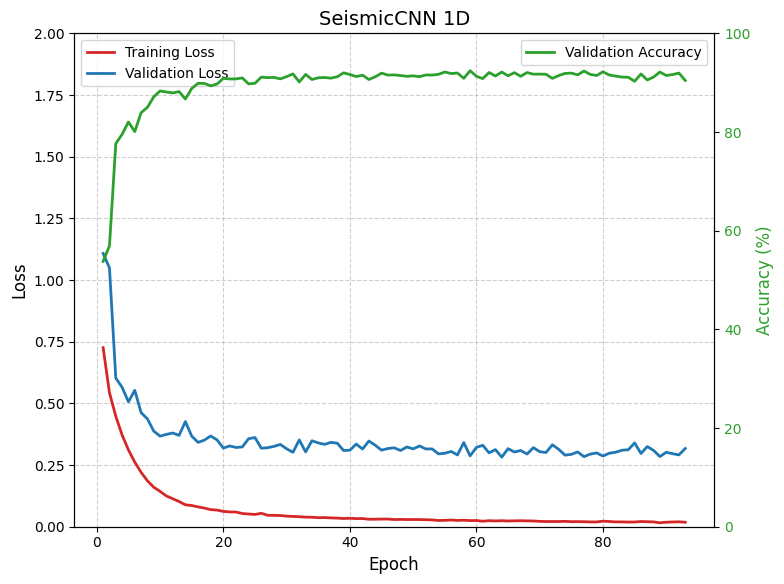

In [35]:


plot_model_training(loss_time_seismiccnn_1d, val_loss_time_seismiccnn_1d, val_accuracy_time_seismiccnn_1d)

/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/utils.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_labels = torch.nn.functional.one_hot(torch.tensor(sample_labels), num_classes=self.num_classes)


test loss: 0.282 and accuracy: 92.150


/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/utils.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_labels = torch.nn.functional.one_hot(torch.tensor(sample_labels), num_classes=self.num_classes)


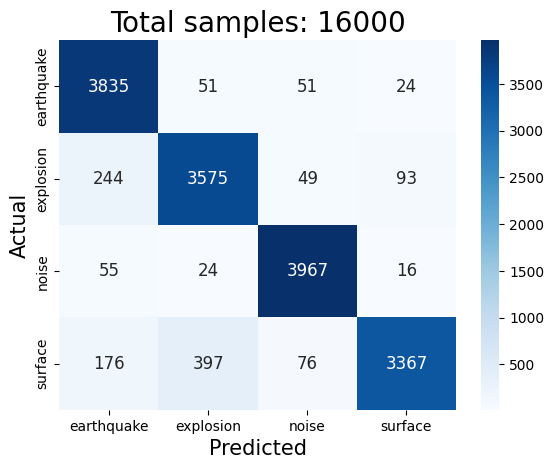

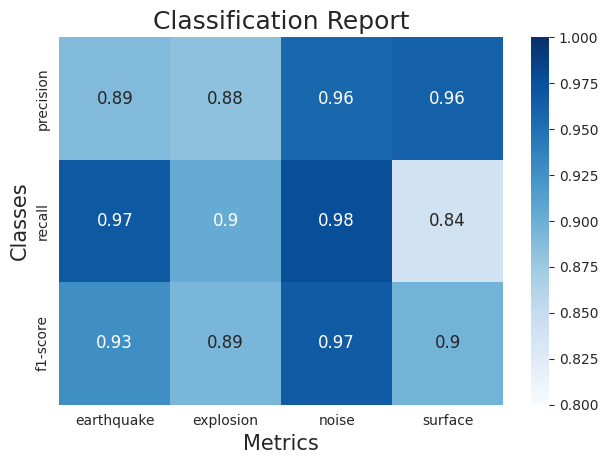

In [36]:
cm_seismiccnn_1d, cr_seismiccnn_1d = plot_confusion_matrix_and_cr(model_seismiccnn_1d, val_loader_1d, show_plot = True, criterion = criterion, batch_size = batch_size)

## SeismicCNN 2D

In [23]:
n_epochs = 100
device = 'cuda'

model_seismiccnn_2d = SeismicCNN_2d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
(loss_time_seismiccnn_2d, val_loss_time_seismiccnn_2d, val_accuracy_time_seismiccnn_2d, model_training_time_seismiccnn_2d) = train_model(model_seismiccnn_2d,
    train_loader_2d,  
    val_loader_2d, 
    n_epochs=n_epochs,
    learning_rate=learning_rate,
    criterion=criterion,augmentation= False, patience = 30, model_path = '../trained_models/best_model_new_augmented_esec_exp_' )

  0%|          | 0/100 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/utils.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_labels = torch.nn.functional.one_hot(torch.tensor(sample_labels), num_classes=self.num_classes)
 10%|█         | 10/100 [01:07<10:04,  6.72s/it]

[Epoch 10] loss: 0.304 - accuracy: 88.331


 20%|██        | 20/100 [02:14<08:55,  6.69s/it]

[Epoch 20] loss: 0.216 - accuracy: 91.675


 30%|███       | 30/100 [03:25<08:10,  7.01s/it]

[Epoch 30] loss: 0.172 - accuracy: 92.981


 40%|████      | 40/100 [04:26<06:03,  6.07s/it]

[Epoch 40] loss: 0.148 - accuracy: 93.119


 50%|█████     | 50/100 [05:26<05:02,  6.05s/it]

[Epoch 50] loss: 0.136 - accuracy: 93.969


 60%|██████    | 60/100 [06:27<04:02,  6.06s/it]

[Epoch 60] loss: 0.122 - accuracy: 93.800


 70%|███████   | 70/100 [07:27<03:01,  6.03s/it]

[Epoch 70] loss: 0.113 - accuracy: 93.763


 80%|████████  | 80/100 [08:28<02:00,  6.04s/it]

[Epoch 80] loss: 0.105 - accuracy: 93.944


 90%|█████████ | 90/100 [09:28<01:00,  6.05s/it]

[Epoch 90] loss: 0.105 - accuracy: 93.844


100%|██████████| 100/100 [10:29<00:00,  6.29s/it]

[Epoch 100] loss: 0.099 - accuracy: 94.438


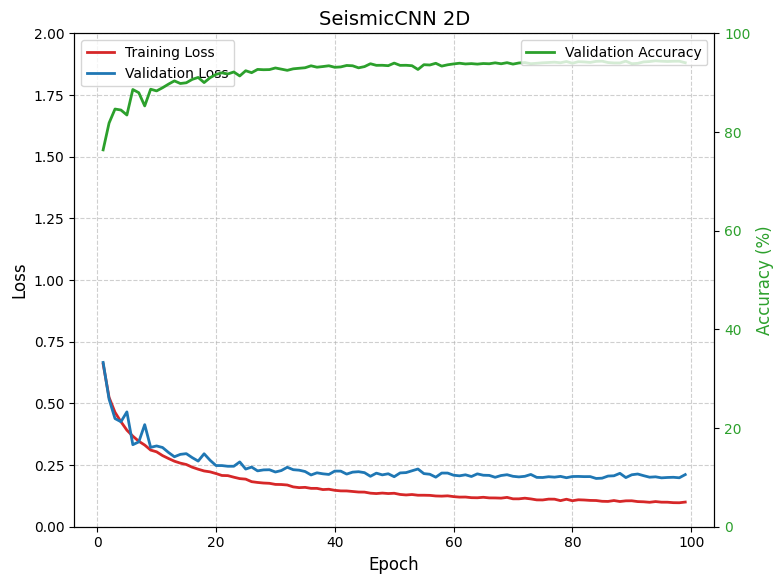

In [26]:
plot_model_training(loss_time_seismiccnn_2d, val_loss_time_seismiccnn_2d, val_accuracy_time_seismiccnn_2d, title = 'SeismicCNN 2D')

/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/utils.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_labels = torch.nn.functional.one_hot(torch.tensor(sample_labels), num_classes=self.num_classes)


test loss: 0.196 and accuracy: 94.319


/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/utils.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_labels = torch.nn.functional.one_hot(torch.tensor(sample_labels), num_classes=self.num_classes)


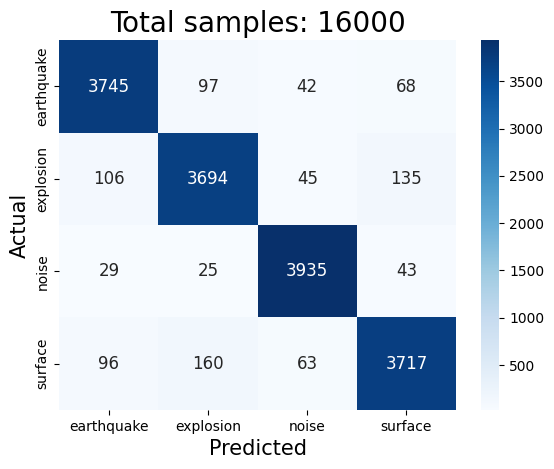

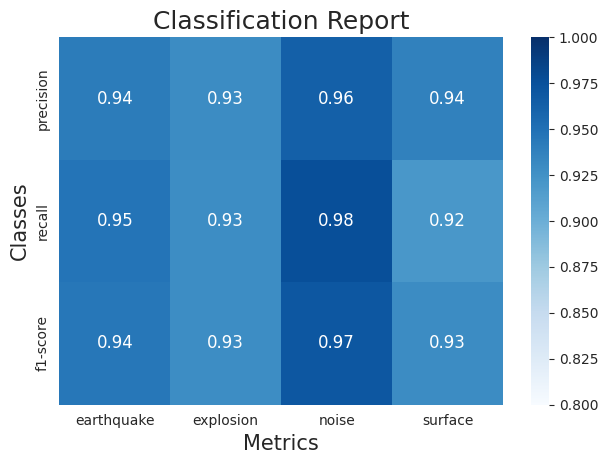

In [27]:
cm_seismiccnn_2d, cr_seismiccnn_2d = plot_confusion_matrix_and_cr(model_seismiccnn_2d, val_loader_2d, show_plot = True, criterion = criterion, batch_size = batch_size)

## QuakeXNet (1D)

In [29]:
model_quakexnet_1d = QuakeXNet_1d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
(loss_time_quakexnet_1d, val_loss_time_quakexnet_1d, val_accuracy_time_quakexnet_1d, model_training_time_quakexnet_1d) = train_model(model_quakexnet_1d,
    train_loader_1d,  val_loader_1d, n_epochs=n_epochs,learning_rate=learning_rate,
    criterion=criterion,augmentation= False, patience = 30, model_path = '../trained_models/best_model_new_augmented_esec_exp_')

  0%|          | 0/100 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/utils.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_labels = torch.nn.functional.one_hot(torch.tensor(sample_labels), num_classes=self.num_classes)
 10%|█         | 10/100 [00:50<07:29,  4.99s/it]

[Epoch 10] loss: 0.369 - accuracy: 73.625


 20%|██        | 20/100 [01:39<06:37,  4.97s/it]

[Epoch 20] loss: 0.310 - accuracy: 78.525


 30%|███       | 30/100 [02:29<05:46,  4.95s/it]

[Epoch 30] loss: 0.268 - accuracy: 81.612


 40%|████      | 40/100 [03:19<04:57,  4.96s/it]

[Epoch 40] loss: 0.234 - accuracy: 82.100


 50%|█████     | 50/100 [04:08<04:07,  4.95s/it]

[Epoch 50] loss: 0.208 - accuracy: 82.794


 60%|██████    | 60/100 [04:58<03:19,  4.98s/it]

[Epoch 60] loss: 0.190 - accuracy: 81.969


 70%|███████   | 70/100 [05:47<02:27,  4.92s/it]

[Epoch 70] loss: 0.175 - accuracy: 81.831


 80%|████████  | 80/100 [06:38<01:41,  5.08s/it]

[Epoch 80] loss: 0.157 - accuracy: 83.769


 90%|█████████ | 90/100 [07:27<00:49,  4.95s/it]

[Epoch 90] loss: 0.151 - accuracy: 84.056


100%|██████████| 100/100 [08:16<00:00,  4.97s/it]

[Epoch 100] loss: 0.141 - accuracy: 83.888


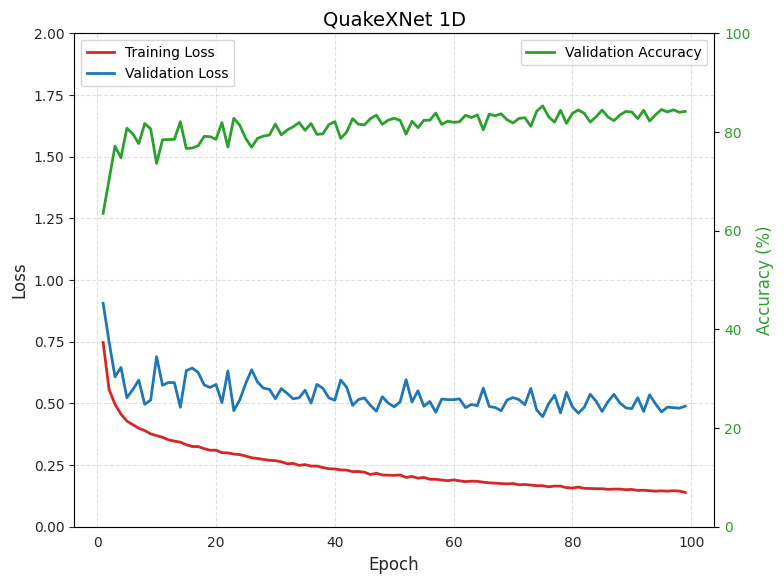

In [30]:
plot_model_training(loss_time_quakexnet_1d, val_loss_time_quakexnet_1d, val_accuracy_time_quakexnet_1d, title = 'QuakeXNet 1D')

/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/utils.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_labels = torch.nn.functional.one_hot(torch.tensor(sample_labels), num_classes=self.num_classes)


test loss: 0.446 and accuracy: 85.300


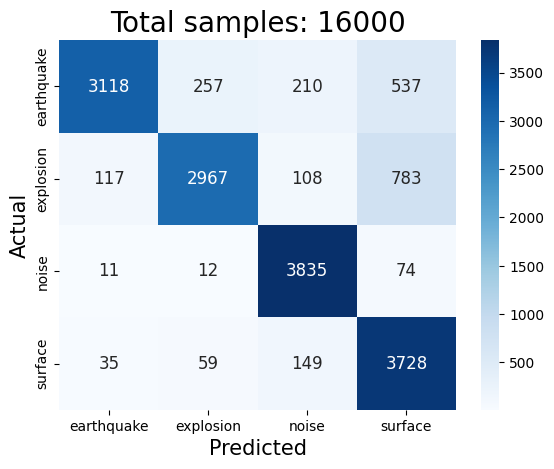

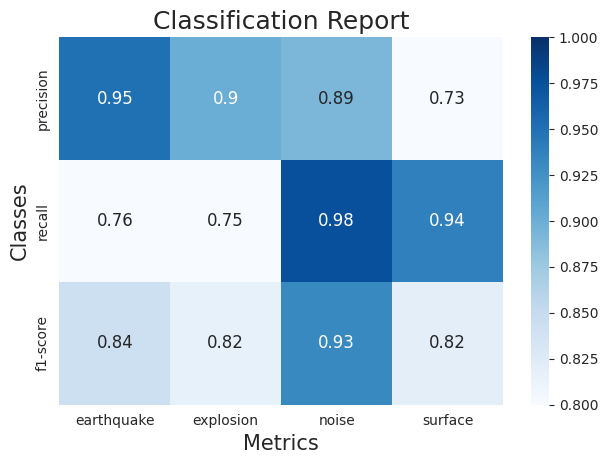

In [33]:
cm_quakexnet_1d, cr_quakexnet_1d = plot_confusion_matrix_and_cr(model_quakexnet_1d, val_loader_1d, show_plot = True, criterion = criterion, batch_size = batch_size)

## QuakeXNet 2D

In [85]:
model_quakexnet_2d = QuakeXNet_2d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
(loss_time_quakexnet_2d, val_loss_time_quakexnet_2d, val_accuracy_time_quakexnet_2d, model_training_time_quakexnet_2d) = train_model(model_quakexnet_2d,
    train_loader_2d,  
    val_loader_2d, 
    n_epochs=n_epochs,
    learning_rate=learning_rate,
    criterion=criterion,augmentation= False, patience = 30, model_path = '../trained_models/best_model_new_augmented_esec_exp_')

  0%|          | 0/100 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/utils.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_labels = torch.nn.functional.one_hot(torch.tensor(sample_labels), num_classes=self.num_classes)
 10%|█         | 10/100 [00:58<08:43,  5.82s/it]

[Epoch 10] loss: 0.528 - accuracy: 83.713


 20%|██        | 20/100 [01:56<07:44,  5.81s/it]

[Epoch 20] loss: 0.482 - accuracy: 85.875


 30%|███       | 30/100 [02:54<06:47,  5.82s/it]

[Epoch 30] loss: 0.459 - accuracy: 86.188


 40%|████      | 40/100 [03:52<05:47,  5.79s/it]

[Epoch 40] loss: 0.445 - accuracy: 86.350


 50%|█████     | 50/100 [04:50<04:49,  5.80s/it]

[Epoch 50] loss: 0.436 - accuracy: 87.544


 60%|██████    | 60/100 [05:48<03:51,  5.78s/it]

[Epoch 60] loss: 0.430 - accuracy: 85.075


 70%|███████   | 70/100 [06:46<02:53,  5.79s/it]

[Epoch 70] loss: 0.425 - accuracy: 85.513


 80%|████████  | 80/100 [07:44<01:55,  5.78s/it]

[Epoch 80] loss: 0.422 - accuracy: 84.850


 90%|█████████ | 90/100 [08:42<00:57,  5.79s/it]

[Epoch 90] loss: 0.414 - accuracy: 87.150


100%|██████████| 100/100 [09:39<00:00,  5.80s/it]

[Epoch 100] loss: 0.415 - accuracy: 87.375


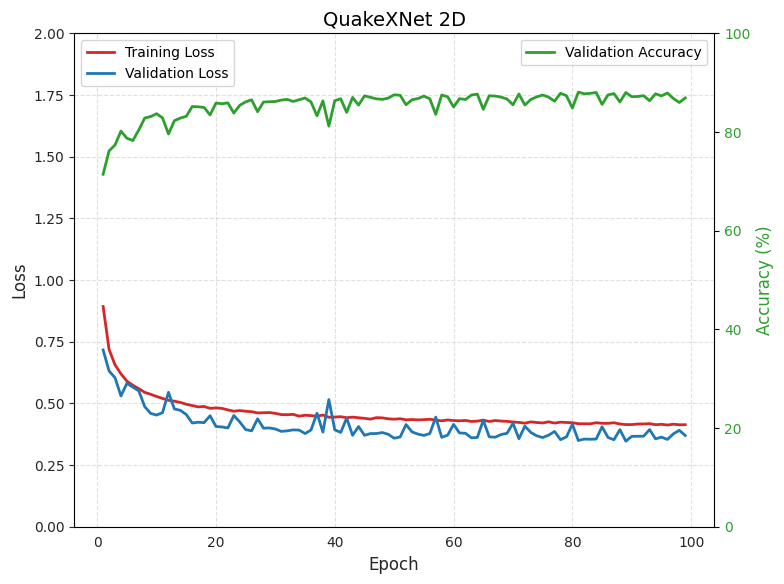

In [86]:
plot_model_training(loss_time_quakexnet_2d, val_loss_time_quakexnet_2d, val_accuracy_time_quakexnet_2d, title = 'QuakeXNet 2D')

/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/utils.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_labels = torch.nn.functional.one_hot(torch.tensor(sample_labels), num_classes=self.num_classes)


test loss: 0.347 and accuracy: 88.013


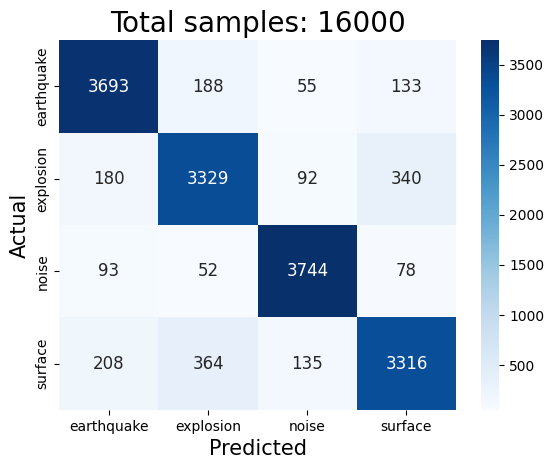

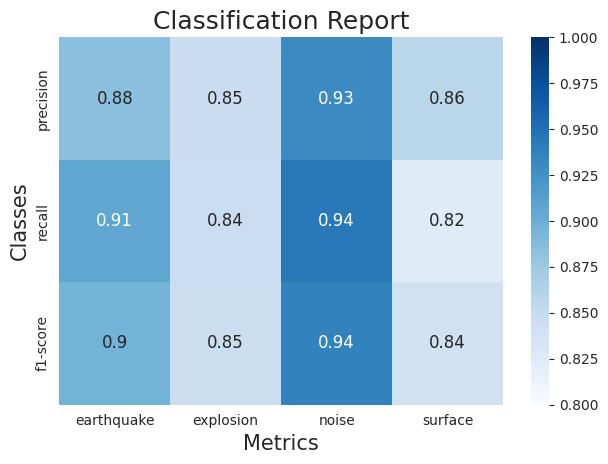

In [87]:
cm_quakexnet_2d, cr_quakexnet_2d = plot_confusion_matrix_and_cr(model_quakexnet_2d, val_loader_2d, show_plot = True, criterion = criterion, batch_size = batch_size)